In [1]:
import numpy as np
import neptune
import imageio
import scipy as scipy
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os

import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from src.data_loader import Shifted_Data_Loader
from src.data_generator import ShiftedDataBatcher

from src.plot import orig_vs_transformed as plot_ovt
from src.data_loader import _shift_image
from src.test_models.drduplex import DRDuplex

Using TensorFlow backend.


In [2]:
exp_date = '2019-09-26'
proj_root = '/home/elijahc/projects/vae'
models_root = os.path.join(proj_root,'models',exp_date)

In [3]:
PROPS = {
    'dataset':'fashion_mnist',
    'encoder_arch': 'dense',
    'generator_arch': 'resnet',
    'augmentation': 'single',
}
PARAMS = {}

train_conf = {
    'n_epochs': 54000,
    'batch_sz':512,
}

data_conf = {
    'bg': 'natural',
    'im_translation':0.75,
    'im_rotation':None,
    'bg_contrast': 0.3,
}

model_conf = {
    'xent_weight': 15,
    'recon_weight': 1,
}

for conf in [train_conf,data_conf,model_conf]:
    PARAMS.update(conf)

In [4]:
PARAMS

{'batch_sz': 512,
 'bg': 'natural',
 'bg_contrast': 0.3,
 'im_rotation': None,
 'im_translation': 0.75,
 'n_epochs': 54000,
 'recon_weight': 1,
 'xent_weight': 15}

In [5]:
oversample_factor=1
DL = Shifted_Data_Loader(dataset=PROPS['dataset'],flatten=False,num_train=60000*oversample_factor,
                         translation=PARAMS['im_translation'],
                         rotation=PARAMS['im_rotation'],
#                          scale_mean0 = True,
#                          contrast_level=PARAMS['bg_contrast'],
                         bg=PARAMS['bg'],
                         blend=None,
                        )

input_shape:  (56, 56, 1)
dataset:  fashion_mnist
background:  natural
blend mode:  None
scale:  2
tx_max:  0.75
rot_max:  None
contrast_level:  1
noise_mode:  None
building background images...


test_images: 100%|██████████| 10000/10000 [00:00<00:00, 34959.03it/s]


In [6]:
DB = ShiftedDataBatcher(dataset=PROPS['dataset'],
                         translation=PARAMS['im_translation'],
                         rotation=PARAMS['im_rotation'],
#                          contrast_level=PARAMS['bg_contrast'],
                         bg=PARAMS['bg'],
                         blend=None,
                        )

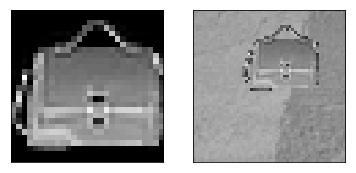

In [7]:
pt,idx = plot_ovt(DL,cmap='gray')

In [8]:
def scale_mean0(X):
    scaler = MinMaxScaler(feature_range=(-1,1),copy=False)
    n,x,y,c = X.shape
    scaler.fit_transform(X.reshape(n,x*y*c))
    X = X.reshape(n,x,y,c)

In [9]:
for X in [DL.sx_train,DL.sx_test,DL.fg_train,DL.fg_test]:
    print(X.min(),X.max())
    scale_mean0(X)
    print(X.min(),X.max())

0.0907843142747879 0.950000011920929
-1.0000000000000002 1.0000000000000004
0.09162596133361142 0.950000011920929
-1.0000000000000002 1.0000000000000004
0.0 1.0
-1.0 1.0
0.0 1.0
-1.0 1.0


In [12]:
neptune.init('elijahc/DuplexAE')
src_files = ['./src/data_loader.py','./src/test_models/drduplex.py']
exp = neptune.create_experiment(name='static_aug_w_recon',properties=PROPS,params=PARAMS,upload_source_files=src_files)
exp_dir = os.path.join('models',exp_date,exp.id) 

os.mkdir(os.path.join(proj_root,exp_dir))
os.mkdir(os.path.join(proj_root,exp_dir,'recons'))
os.mkdir(os.path.join(proj_root,exp_dir,'test_ims'))

exp.set_property('dir',exp_dir)

https://ui.neptune.ml/elijahc/DuplexAE/e/DPX-24


Experiment(DPX-24)

In [13]:
w_xent = PARAMS['xent_weight']
w_recon = PARAMS['recon_weight']

In [14]:
mod = DRDuplex(img_shape=(56,56,1),
               num_classes=DL.num_classes,
               recon=w_recon,
               xent=w_xent,n_residual_blocks=4,
#                kernel_regularization=1e-5,
              )

In [15]:
mod.combined.metrics_names

['loss',
 'Generator_loss',
 'Classifier_loss',
 'Generator_mean_squared_error',
 'Classifier_acc']

In [16]:
val_pct = 0.05
val_idxs = np.random.choice(np.arange(10000),int(val_pct*60000),replace=False)
validation_set = (DL.sx_test[val_idxs],
                  {'Classifier':DL.y_test_oh[val_idxs],
                   'Generator':DL.fg_test[val_idxs]}
                 )

In [17]:
i = 0
epoch_sz = int(DL.num_train/512)
pan_ims = []
pan_y = []

# hist_labels = mod.combined.metrics_names
hist_labels = ['loss','G_loss','C_loss','G_mse','acc']

train_hist = []
test_hist = []

# val_X,val_X_fg,val_y = DB.gen_batch(DB.x_te,DB.y_test_oh,batch_size=1000,bg='natural')


In [18]:
num_pan = 3
not_unique = True
while not_unique:
    pan_idx = np.random.choice(np.arange(len(DL.sx_test)),size=num_pan,replace=False)
    if len(np.unique(DL.y_test[pan_idx])) == num_pan:
        not_unique = False
    
px_ = DL.x_test[pan_idx]
print(px_.shape)
# tX, tX_fg,ty = next(test_generator)

(3, 28, 28)


In [19]:
x_span = DB.gen_pan_deltas(step=2)
pX = np.stack([np.expand_dims(_shift_image(X=px_,dx=dx,dy=dy),-1) for dx,dy in x_span])

scaler = MinMaxScaler(feature_range=(-1,1))
n,r,x,y,c = pX.shape

pX = scaler.fit_transform(pX.reshape(n,x*y*c*r)).reshape(n,r,x,y,c)

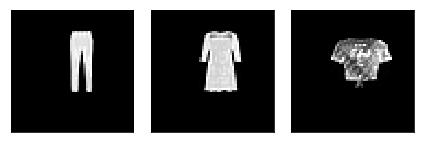

In [20]:
fig,axs = plt.subplots(1,num_pan)
for i,ax in enumerate(axs.ravel()):
    ax.imshow(pX[27,i].reshape(56,56),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.tight_layout()

In [21]:
# import numpy as np
# nj = 25
# fig,axs = plt.subplots(1,nj,figsize=(2*nj,2))

# for i in np.arange(nj):
#     axs[i].imshow(pX[i+15].reshape(56,56))

In [22]:
def flush_pan(pan_ims):
    min_max = lambda xp: np.clip((xp+1)/2,0,1)
    for idx,inp,G in pan_ims:
        idx = str(idx).zfill(3)
        
#         inp_fn = 'input_{}.png'.format(idx)
#         inp_fp = os.path.join(proj_root,exp_dir,'test_ims',inp_fn)
        
        G_fn = 'G_{}.png'.format(idx)
        G_fp = os.path.join(proj_root,exp_dir,'recons',G_fn)
    
        fig,axs = plt.subplots(2,num_pan)
        for k in np.arange(num_pan):
            axs[0,k].imshow(inp[k],cmap='gray')
            axs[1,k].imshow(G[k],cmap='gray')

        for ax in axs.ravel():
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        plt.tight_layout()     
        
        fig.savefig(G_fp)
        plt.close(fig)

In [23]:
recon_dir = os.path.join(proj_root,exp_dir,'recons')
input_dir = os.path.join(proj_root,exp_dir,'test_ims')

In [24]:
def make_gif(recon_dir,input_dir,fps=8,loop=0):
    G_ims = []
    for G in sorted(os.listdir(recon_dir)):
        if G.endswith('.png'):
            G_fp = os.path.join(recon_dir, G)
            G_ims.append(imageio.imread(G_fp))
        
#     imageio.mimsave(os.path.join(proj_root,exp_dir,'inputs_video.gif'), input_ims,fps=fps,loop=loop)
    imageio.mimsave(os.path.join(proj_root,exp_dir,'G_video.gif'), G_ims, fps=fps,loop=loop)

In [25]:
def save_model(mod,mod_dir,spec_fn='model.json'):
    model_json = mod.to_json()
    with open(os.path.join(mod_dir,spec_fn), "w") as json_file:
        json_file.write(model_json)
        
def save_weights(mod,mod_dir,weights_fn='weights.h5'):
        mod.save_weights(os.path.join(mod_dir,weights_fn))

def save_model_and_weights(mod,mod_dir,spec_fn='model.json',weights_fn='weights.h5'):
    save_model(mod,mod_dir,spec_fn)
    save_weights(mod,mod_dir,weights_fn)

In [26]:
from keras.callbacks import Callback

class ReconCallback(Callback):
    def __init__(self,pX,pan_ims,pan_y):
        self.pX = pX
        self.pan_ims = pan_ims
        self.pan_y = pan_y
        self.recon_dir = recon_dir
        self.input_dir = input_dir

    def on_epoch_end(self,epoch,logs={}):
        pidx = int(epoch%len(self.pX))
        im = pX[pidx]
        p_recon,p_class = self.model.predict_on_batch(im)
        
        pan_im = (int(epoch), np.squeeze(im), np.squeeze(p_recon))
        self.pan_ims.append(pan_im)
        self.pan_y.append(p_class)
        
        
        if len(self.pan_ims)>int(len(pX)/3):
            print('writing_image_buffer...')
            flush_pan(self.pan_ims)
            self.pan_ims = []
                
            print('recompiling video...')
            make_gif(self.recon_dir,self.input_dir)
            
class NeptuneMonitor(Callback):        
    def on_epoch_end(self, epoch, logs={}):
#         innovative_metric = logs['acc'] - 2 * logs['loss']
        neptune.send_metric('loss', logs['loss'])
        neptune.send_metric('val_loss', logs['val_loss'])
        neptune.send_metric('C_loss', logs['Classifier_loss'])
        neptune.send_metric('val_C_loss', logs['val_Classifier_loss'])
        neptune.send_metric('G_loss', logs['Generator_loss'])
        neptune.send_metric('acc', logs['Classifier_acc'])
        neptune.send_metric('val_acc', logs['val_Classifier_acc'])
        neptune.send_metric('batch',int(epoch*117))
        
            
class ModelCheckpointer(Callback):
    def __init__(self, save_dir, monitor='val_loss'):
        self.metric = monitor
        self.save_dir = save_dir
        self.best_val = np.inf
    
    def on_train_begin(self,logs={}):
        print('monitoring {} to checkpoint model'.format(self.metric))
        print('saving model spec and initial weights...')
        save_model(self.model,self.save_dir)
        save_weights(self.model,self.save_dir,'weights.h5')
        
    def on_train_end(self,logs={}):
        save_weights(self.model,self.save_dir,'final_weights.h5')
    
    def on_epoch_end(self, epoch, logs={}):
        if epoch > 5 and logs[self.metric] < self.best_val:
            self.best_val = logs[self.metric]
            save_weights(self.model,self.save_dir,'weights.h5')

In [27]:
neptune_monitor = NeptuneMonitor()
checkpointer = ModelCheckpointer(save_dir=os.path.join(proj_root,exp_dir),
                                 monitor='val_Classifier_loss',
                                )
reconcb = ReconCallback(pX, pan_ims, pan_y)
cbs = [neptune_monitor,checkpointer,reconcb]

In [28]:
mod.combined.fit(DL.sx_train,y={'Classifier':DL.y_train_oh,'Generator':DL.fg_train},
                 batch_size=PARAMS['batch_sz'],validation_data=validation_set,callbacks=cbs,epochs=int(54000/117),
                 verbose=0
                )

monitoring val_Classifier_loss to checkpoint model
saving model spec and initial weights...
writing_image_buffer...
recompiling video...
writing_image_buffer...
recompiling video...
writing_image_buffer...
recompiling video...
writing_image_buffer...
recompiling video...
writing_image_buffer...
recompiling video...
writing_image_buffer...
recompiling video...
writing_image_buffer...
recompiling video...


KeyboardInterrupt: 

In [30]:
flush_pan(reconcb.pan_ims)
make_gif(recon_dir,input_dir)

In [31]:
mod_dir = os.path.join(proj_root,exp_dir)
mod_dir

'/home/elijahc/projects/vae/models/2019-09-26/DPX-24'

In [32]:
save_weights(mod.combined,mod_dir,'final_weights.h5')

In [33]:
exp.stop()

In [34]:
train_hist = mod.combined.history.history

In [35]:
hist_tr = pd.DataFrame.from_records(train_hist)

In [36]:
hist_labels = ['loss','G_loss','C_loss','G_mse','acc']

In [37]:
col_map = {k:v for k,v in zip(mod.combined.metrics_names,hist_labels)}
hist_tr = hist_tr.rename(columns=col_map)

In [38]:
print(mod_dir)
hist_tr.to_csv(os.path.join(mod_dir,'training_hist.csv'))

/home/elijahc/projects/vae/models/2019-09-26/DPX-24


In [ ]:
teX,_,_ = next(test_generator)

In [ ]:
out = mod.combined.predict_on_batch(teX)

In [ ]:
x_recon,y = out

In [ ]:
choices = np.random.choice(np.arange(1024),size=5,replace=False)

In [ ]:
fix,axes = plt.subplots(2,5,figsize=(2*5,2*2))

for i,idx in enumerate(choices):
    axs = axes[:,i]
    axs[0].imshow(teX[idx].reshape(56,56),cmap='gray')
    axs[1].imshow(x_recon[idx].reshape(56,56),cmap='gray')
    
for ax in axes.ravel():
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    
plt.tight_layout()

In [ ]:
fix.savefig(os.path.join(mod_dir,'inp_output_pairs.png'),dpi=300)

In [ ]:
exp.send_artifact(os.path.join(mod_dir,'inp_output_pairs.png'))

In [ ]:
x_tr = DL.sx_train
x_tro = DL.x_train

In [ ]:
x_tro.shape

In [ ]:
im = np.squeeze(x_tr[5])
plt.imshow(x_tro[5])

In [ ]:
x_t_warp = np.zeros((28,28))
xt_warp = scipy.ndimage.zoom(x_tro[5],(1.1,0.9))
plt.imshow(xt_warp)

In [ ]:
DL.meta_train